In [1]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import torch
import torchdiffeq
import torchsde
from torchdyn.core import NeuralODE
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid
from tqdm import tqdm

from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel
import numpy as np

savedir = "models/cond_mnist"
os.makedirs(savedir, exist_ok=True)

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
batch_size = 128*4
n_epochs = 10

trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)

cuda


In [ ]:
#################################
#    Class Conditional CFM
#################################

sigma = 0.0
model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)
optimizer = torch.optim.Adam(model.parameters())
FM = ConditionalFlowMatcher(sigma=sigma)
# Users can try target FM by changing the above line by
# FM = TargetConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [7]:
for epoch in range(n_epochs):
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        y = data[1].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt, y)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
        print(f"epoch: {epoch}, steps: {i}, loss: {loss.item():.4}", end="\r")

KeyboardInterrupt: 

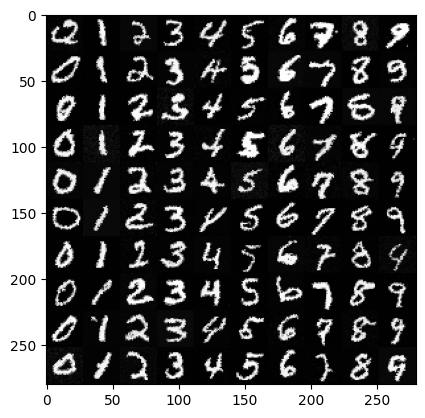

In [ ]:
USE_TORCH_DIFFEQ = True
generated_class_list = torch.arange(10, device=device).repeat(10)
with torch.no_grad():
    if USE_TORCH_DIFFEQ:
        traj = torchdiffeq.odeint(
            lambda t, x: model.forward(t, x, generated_class_list),
            torch.randn(100, 1, 28, 28, device=device),
            torch.linspace(0, 1, 2, device=device),
            atol=1e-4,
            rtol=1e-4,
            method="dopri5",
        )
    else:
        traj = node.trajectory(
            torch.randn(100, 1, 28, 28, device=device),
            t_span=torch.linspace(0, 1, 2, device=device),
        )
grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [14]:
#################################
#            OT-CFM Vanilla
#################################

sigma = 0.0
model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
p_unsupervised = 0

In [15]:
for epoch in range(n_epochs):
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        y = data[1].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut, _, y1 = FM.guided_sample_location_and_conditional_flow(x0, x1, y1=y)
        vt = model(t, xt, y1)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
        print(f"epoch: {epoch}, steps: {i}, loss: {loss.item():.4}", end="\r")

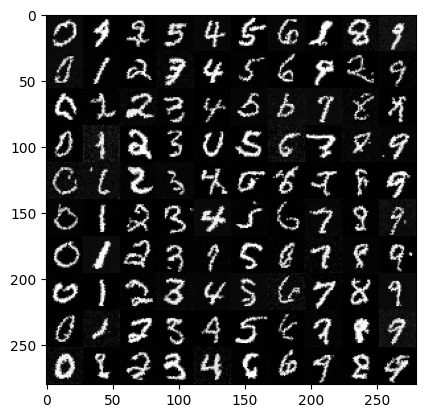

In [16]:
USE_TORCH_DIFFEQ = True
generated_class_list = torch.arange(10, device=device).repeat(10)
with torch.no_grad():
    if USE_TORCH_DIFFEQ:
        traj = torchdiffeq.odeint(
            lambda t, x: model.forward(t, x, generated_class_list),
            torch.randn(100, 1, 28, 28, device=device),
            torch.linspace(0, 1, 2, device=device),
            atol=1e-4,
            rtol=1e-4,
            method="dopri5",
        )
    else:
        traj = node.trajectory(
            torch.randn(100, 1, 28, 28, device=device),
            t_span=torch.linspace(0, 1, 2, device=device),
        )
grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [ ]:
#################################
#            OT-CFM 11 classes
#################################

sigma = 0.0
model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=11, class_cond=True
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
p_unsupervised = 0

In [12]:
for epoch in range(n_epochs):
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        y = data[1].to(device)
        filter = np.random.random(y.shape) < p_unsupervised
        y[filter] = 10
        x0 = torch.randn_like(x1)
        t, xt, ut, _, y1 = FM.guided_sample_location_and_conditional_flow(x0, x1, y1=y)
        vt = model(t, xt, y1)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
        print(f"epoch: {epoch}, steps: {i}, loss: {loss.item():.4}", end="\r")

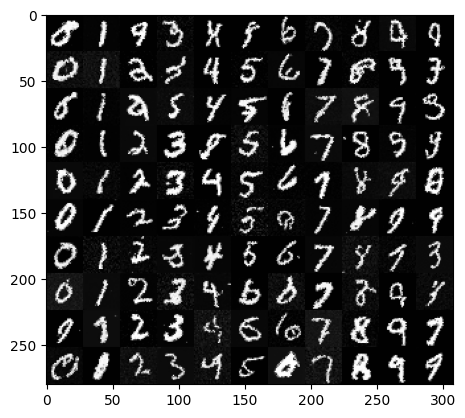

In [13]:
USE_TORCH_DIFFEQ = True
generated_class_list = torch.arange(11, device=device).repeat(10)
with torch.no_grad():
    if USE_TORCH_DIFFEQ:
        traj = torchdiffeq.odeint(
            lambda t, x: model.forward(t, x, generated_class_list),
            torch.randn(110, 1, 28, 28, device=device),
            torch.linspace(0, 1, 2, device=device),
            atol=1e-4,
            rtol=1e-4,
            method="dopri5",
        )
    else:
        traj = node.trajectory(
            torch.randn(100, 1, 28, 28, device=device),
            t_span=torch.linspace(0, 1, 2, device=device),
        )
grid = make_grid(
    traj[-1, :110].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=11
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

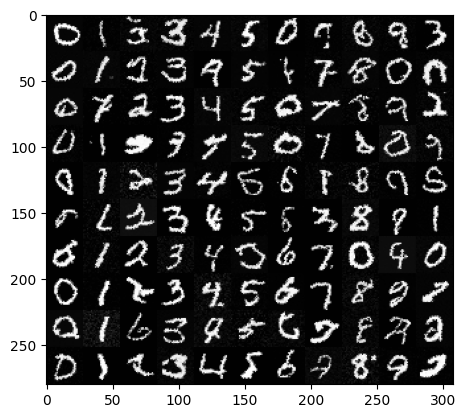

In [ ]:
USE_TORCH_DIFFEQ = True
generated_class_list = torch.arange(11, device=device).repeat(10)
with torch.no_grad():
    if USE_TORCH_DIFFEQ:
        traj = torchdiffeq.odeint(
            lambda t, x: model.forward(t, x, generated_class_list),
            torch.randn(110, 1, 28, 28, device=device),
            torch.linspace(0, 1, 2, device=device),
            atol=1e-4,
            rtol=1e-4,
            method="dopri5",
        )
    else:
        traj = node.trajectory(
            torch.randn(100, 1, 28, 28, device=device),
            t_span=torch.linspace(0, 1, 2, device=device),
        )
grid = make_grid(
    traj[-1, :110].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=11
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [9]:
#################################
#            SF2M
#################################
batch_size = 128
n_epochs = 10
sigma = 0.1


model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)
score_model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)

optimizer = torch.optim.Adam(list(model.parameters()) + list(score_model.parameters()))
FM = SchrodingerBridgeConditionalFlowMatcher(sigma=sigma)
node = NeuralODE(model, solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)

In [10]:
for epoch in range(n_epochs):
    for i, data in tqdm(enumerate(train_loader)):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        y = data[1].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut, _, y1, eps = FM.guided_sample_location_and_conditional_flow(
            x0, x1, y1=y, return_noise=True
        )
        lambda_t = FM.compute_lambda(t)
        vt = model(t, xt, y1)
        st = score_model(t, xt, y1)
        flow_loss = torch.mean((vt - ut) ** 2)
        score_loss = torch.mean((lambda_t[:, None, None, None] * st + eps) ** 2)
        loss = flow_loss + score_loss
        loss.backward()
        optimizer.step()

468it [01:27,  5.38it/s]
468it [01:27,  5.36it/s]
468it [01:27,  5.36it/s]
468it [01:27,  5.37it/s]
468it [01:27,  5.36it/s]
468it [01:27,  5.37it/s]
468it [01:27,  5.37it/s]
468it [01:27,  5.37it/s]
468it [01:27,  5.37it/s]
468it [01:27,  5.37it/s]


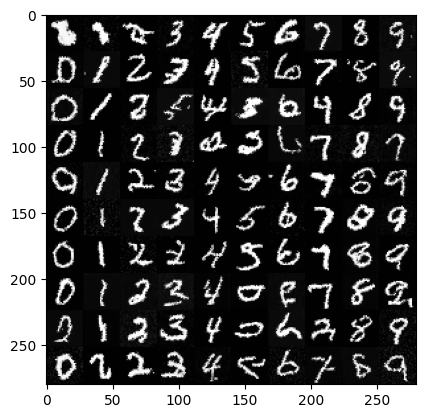

In [11]:
USE_TORCH_DIFFEQ = True
generated_class_list = torch.arange(10, device=device).repeat(10)

node = NeuralODE(model, solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
# Evaluate the ODE
with torch.no_grad():
    if USE_TORCH_DIFFEQ:
        traj = torchdiffeq.odeint(
            lambda t, x: model.forward(t, x, generated_class_list),
            torch.randn(100, 1, 28, 28, device=device),
            torch.linspace(0, 1, 2, device=device),
            atol=1e-4,
            rtol=1e-4,
            method="dopri5",
        )
    else:
        traj = node.trajectory(
            torch.randn(100, 1, 28, 28, device=device),
            t_span=torch.linspace(0, 1, 2, device=device),
        )
grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)

In [12]:
# follows example from https://github.com/google-research/torchsde/blob/master/examples/cont_ddpm.py


class SDE(torch.nn.Module):
    noise_type = "diagonal"
    sde_type = "ito"

    def __init__(self, ode_drift, score, labels=None, reverse=False, sigma=0.1):
        super().__init__()
        self.drift = ode_drift
        self.score = score
        self.reverse = reverse
        self.labels = labels
        self.sigma = sigma

    # Drift

    def f(self, t, y):
        y = y.view(-1, 1, 28, 28)
        if self.reverse:
            t = 1 - t
            return -self.drift(t, y, self.labels) + self.score(t, y, self.labels)
        return self.drift(t, y, self.labels).flatten(start_dim=1) + self.score(
            t, y, self.labels
        ).flatten(start_dim=1)

    # Diffusion
    def g(self, t, y):
        return torch.ones_like(y) * self.sigma

In [13]:
sde = SDE(model, score_model, labels=torch.arange(10, device=device).repeat(10), sigma=0.1)
with torch.no_grad():
    sde_traj = torchsde.sdeint(
        sde,
        # x0.view(x0.size(0), -1),
        torch.randn(100, 1 * 28 * 28, device=device),
        ts=torch.linspace(0, 1, 2, device=device),
        dt=0.01,
    )

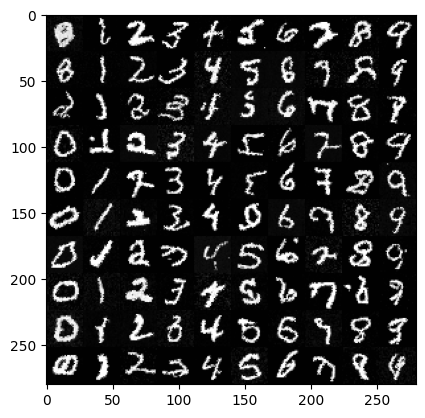

In [14]:
grid = make_grid(
    sde_traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)